## Lec 5. UNet
_______

- 生成式模型
    - 生成对抗网络 `GAN (Generative Adversarial Networks)`
    - Diffusion 扩散模型
        - `UNet`
        - `CLIP`
        - `VAE`

In [14]:
import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### 5.1 图像数据集


In [15]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [16]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

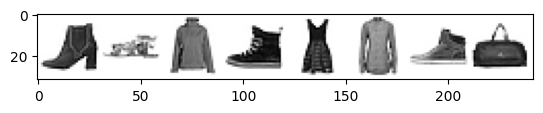

In [17]:
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

### 5.2 添加噪声

In [18]:
def corrupt(x, amount):
    """ 图像添加噪声函数 """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return (1 - amount) * x + amount * noise

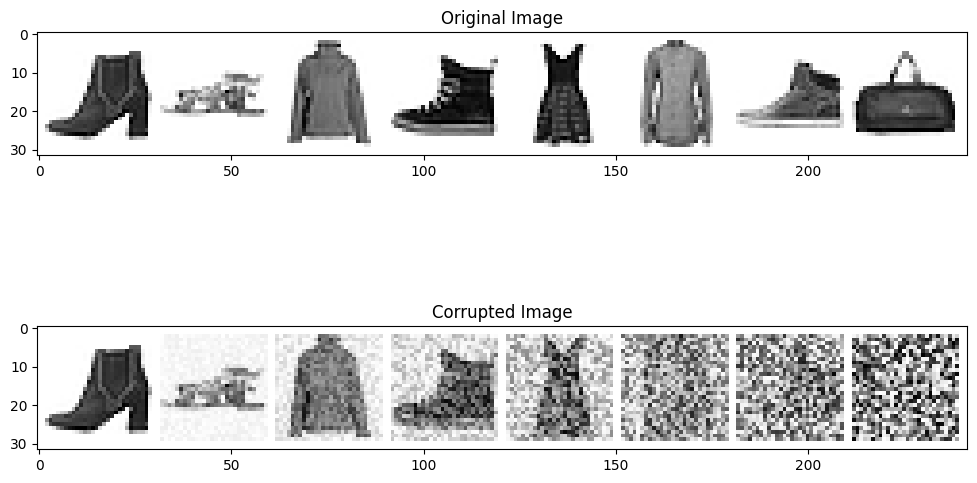

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

amount = torch.linspace(0, 1, x.shape[0])
corrupted_x = corrupt(x, amount)
axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(corrupted_x)[0], cmap="Greys")

### 5.3 BasicUNet 基础UNet

- 下采样
- 上采样

In [20]:
class BasicUNet(nn.Module):
    """ 基础UNet网络 """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # 下采样 - 通道数增多，特征图缩小
        self.down_layers = nn.ModuleList([nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                                          nn.Conv2d(32, 64, kernel_size=5, padding=2),
                                          nn.Conv2d(64, 64, kernel_size=5, padding=2)])
        # 上采样 - 通道数减少，特征图增大
        self.up_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=5, padding=2),
                                        nn.Conv2d(64, 32, kernel_size=5, padding=2),
                                        nn.Conv2d(32, out_channels, kernel_size=5, padding=2)])

        self.activation = nn.ReLU()
        self.downscale = nn.MaxPool2d(kernel_size=2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        """ 前向传播方法 """
        hidden = []  # 用来存储下采样过程的中间结果 [特征图]
        for idx, layer in enumerate(self.down_layers):
            x = self.activation(layer(x))
            if idx < 2:
                hidden.append(x)
                x = self.downscale(x)

        for idx, layer  in enumerate(self.up_layers):
            if idx > 0:
                x = self.upscale(x)
                x = x + hidden.pop()  # ToDo: 测试不加入 hidden 参照的效果
            x = self.activation(layer(x))
        return x

In [21]:
model = BasicUNet(1, 1)
model

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (activation): ReLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [22]:
output = model(x)
output.shape, x.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

### 5.4 模型训练


In [23]:
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0
    for x, _ in dataloader:
        amount = torch.rand(x.shape[0]).to(device)
        corrupted_x = corrupt(x.to(device), amount)

        y_hat = model(corrupted_x)
        loss = loss_func(y_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [24]:
model = BasicUNet(1, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
n_epoch = 10

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {0}")

Epoch 1 loss: 0.0667
Epoch 2 loss: 0.0328
Epoch 3 loss: 0.0291
Epoch 4 loss: 0.0283
Epoch 5 loss: 0.0267
Epoch 6 loss: 0.0262
Epoch 7 loss: 0.0258
Epoch 8 loss: 0.026
Epoch 9 loss: 0.0241
Epoch 10 loss: 0.0234


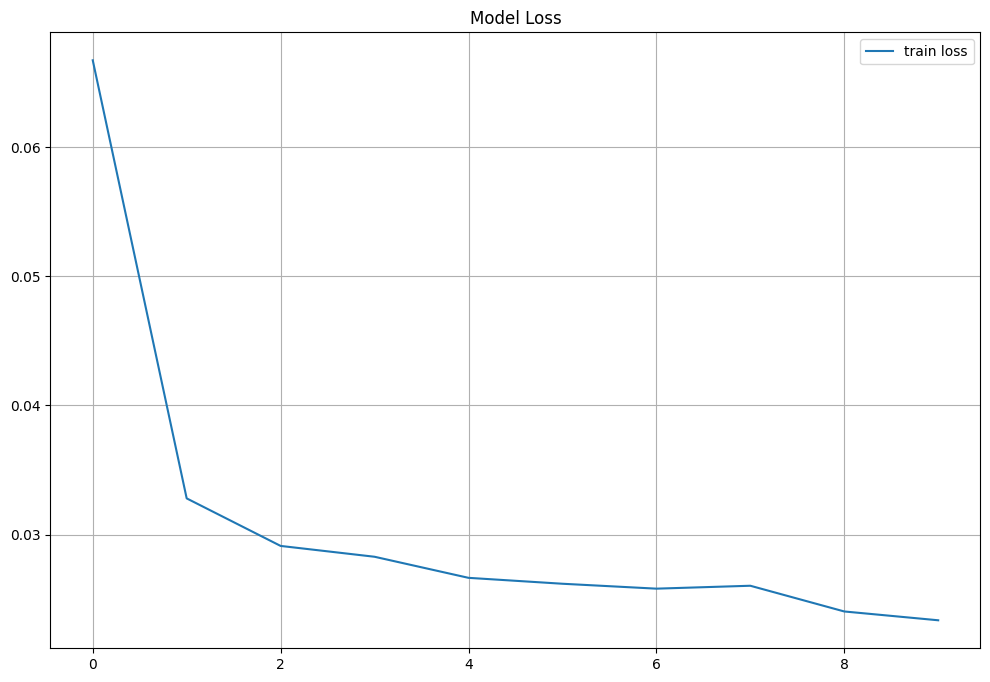

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()

In [27]:
amount = torch.linspace(0, 1, x.shape[0])
corrupted_x = corrupt(x, amount)

with torch.no_grad():
    y_hat = model(corrupted_x).cpu()

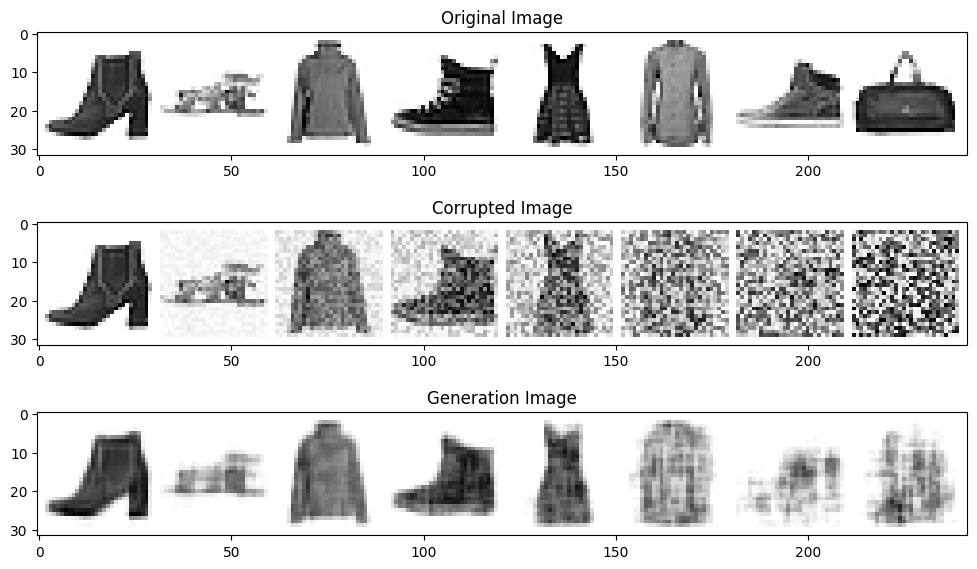

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(corrupted_x)[0], cmap="Greys")

axs[2].set_title("Generation Image")
axs[2].imshow(torchvision.utils.make_grid(y_hat)[0], cmap="Greys")

### 5.5 采样 Sample

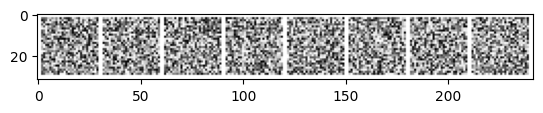

In [31]:
x = torch.rand(8, 1, 28, 28)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [32]:
step_history = [x.cpu()]
output_history = []
n_steps = 10

for i in range(n_steps):
    with torch.no_grad():
        y_hat = model(x.to(device))

    output_history.append(y_hat.cpu())
    mix_factor = 1 / n_steps
    x = (1 - mix_factor) * x + mix_factor * y_hat
    step_history.append(x.cpu())

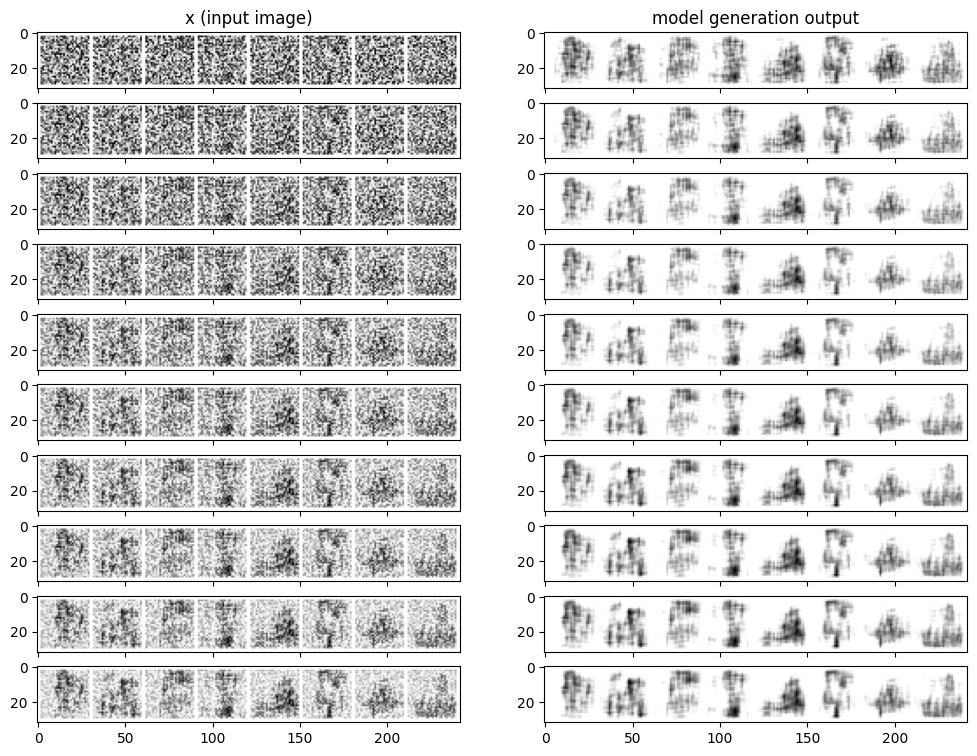

In [33]:
fig, axs = plt.subplots(n_steps, 2, figsize=(12, 9), sharex=True)
axs[0, 0].set_title("x (input image)")
axs[0, 1].set_title("model generation output")

for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(output_history[i])[0].clip(0, 1), cmap="Greys")